In [8]:
# given some description of the encoding rule, expand a logical circuit into an encoded circuit
# this entails interleaving the logical circuit with syndrome measurement and error correction
# each logical operator should be expanded into the encoded manifold as well
# NOTE: we could think about how to generalize this to codes, but for now its okay to keep specific to ours
from quantum_logical.qudit_op import QutritUnitary
from qiskit.circuit.random import random_circuit
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
import qutip as qt
from quantum_logical.basis import RepetitionEncoding
from quantum_logical.basis import QutritPhaseRepetitionCode

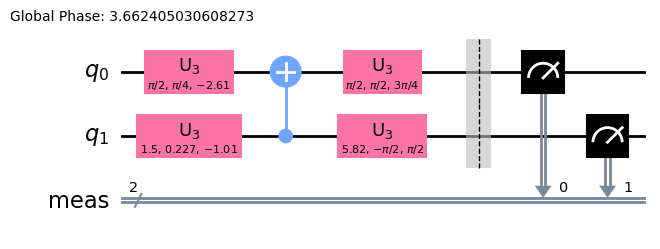

In [9]:
input_circuit = random_circuit(2, 4, seed=42, max_operands=2)
input_circuit = transpile(input_circuit, basis_gates=["u3", "cx"], optimization_level=3)
input_circuit.measure_all()
input_circuit.draw(output="mpl")

To create logical operators use the following transformation:
\begin{align*}
A = |L_0\rangle\langle0| + |L_1\rangle\langle1|\\
U' = A U A^\dagger
\end{align*}
where U is the logical unitary that acts on the $|0\rangle$ and $|1\rangle$ states.


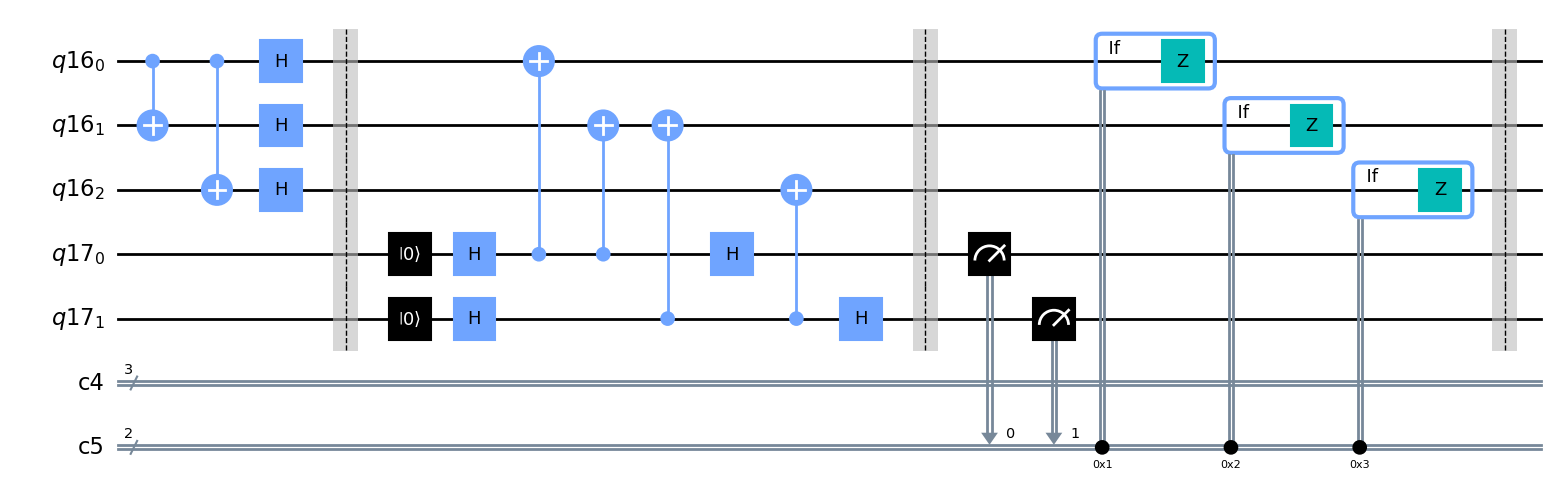

In [10]:
qr = QuantumRegister(3)
ar = QuantumRegister(2)
cqr = ClassicalRegister(3)
car = ClassicalRegister(2)
qc = QuantumCircuit(qr, ar, cqr, car)

encoding = RepetitionEncoding(phase_flip=True)
qc = encoding.encoding_circuit(qc, qr)
qc.barrier()
qc = encoding.stabilizer_subroutine(qc, qr, ar, car)
# encoding.decoding_circuit(qc, qr)
# qc.barrier()
qc.draw("mpl")

/home/evm9/quantum_logical/src/quantum_logical/qudit_op.py:73: UserWarning: Controlled QutritUnitary class is hardcoded to only be CX_gf gate.
  warnings.warn(


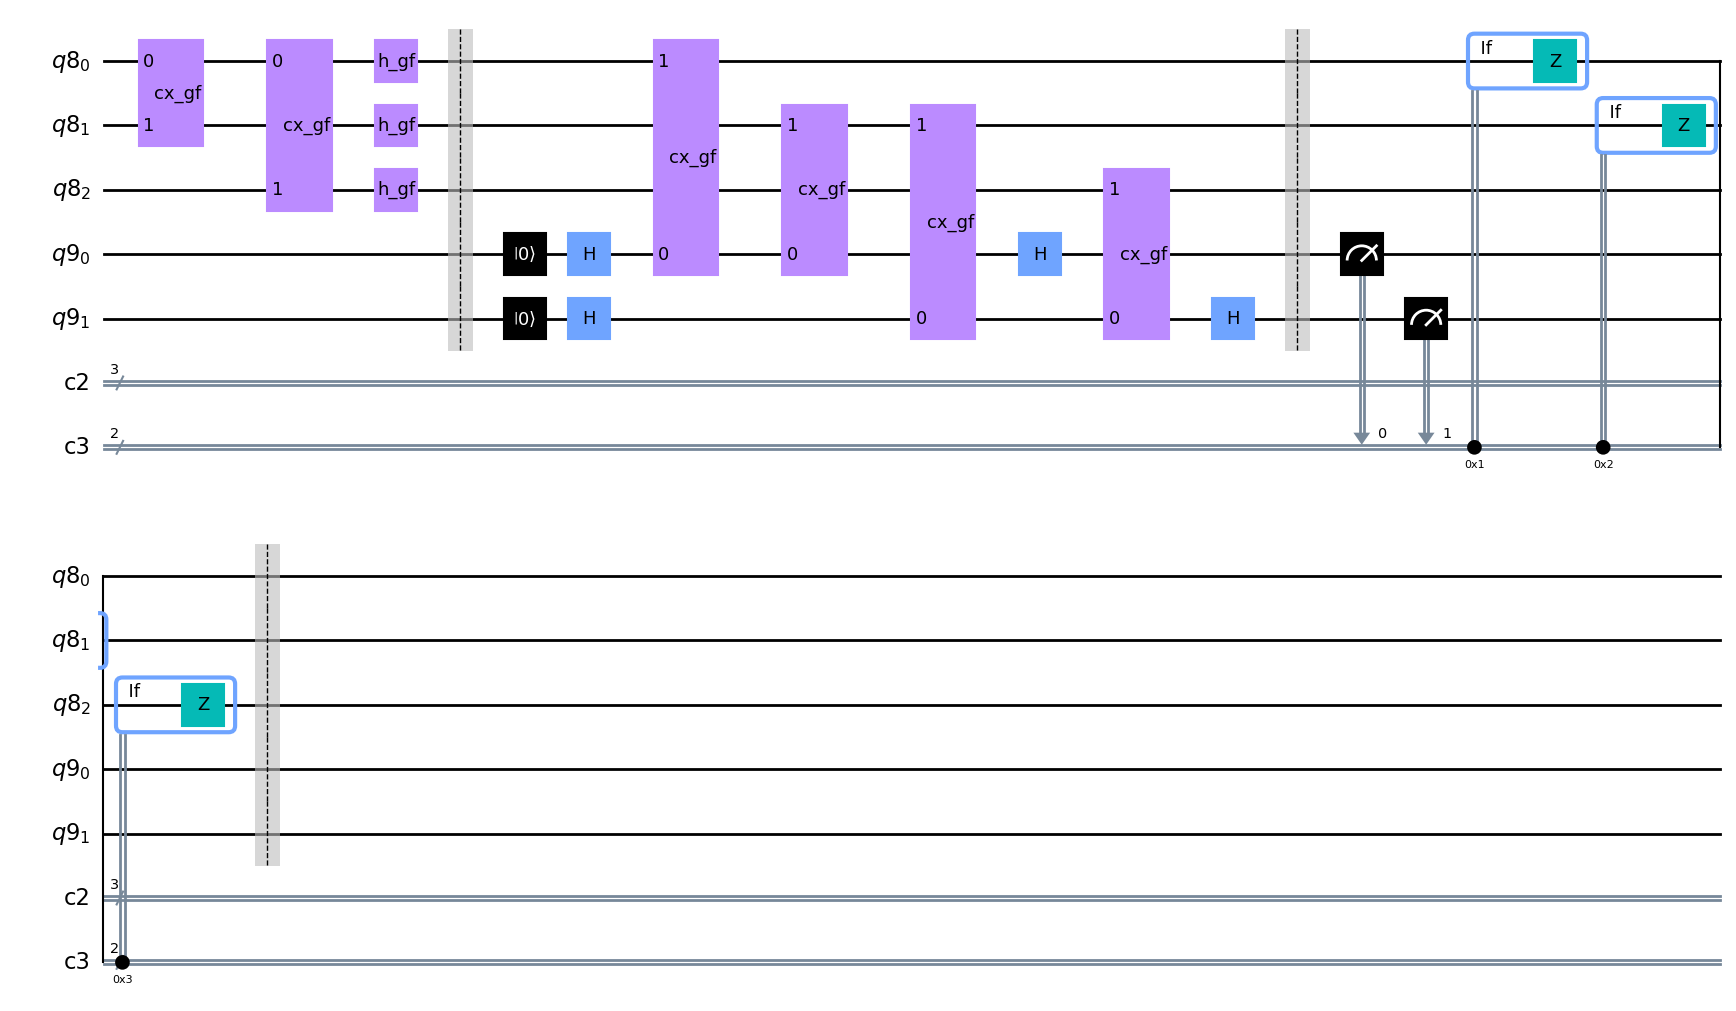

In [4]:
qr = QuantumRegister(3)
ar = QuantumRegister(2)
cqr = ClassicalRegister(3)
car = ClassicalRegister(2)
qc = QuantumCircuit(qr, ar, cqr, car)

encoding = QutritPhaseRepetitionCode()
qc = encoding.encoding_circuit(qc, qr)
qc.barrier()
qc = encoding.stabilizer_subroutine(qc, qr, ar, car)
# qc = encoding.decoding_circuit(qc, qr)
# qc.barrier()
qc.draw("mpl")

In [5]:
# # NOTE: in the expansion pass, we should probably be able to define known rules ahead of time
# # e.g. known translation between logical CNOT and encoded CNOT rather than relying on the
# # mathematical expression which will lead to a harder decomposition problem in the next stage
# from qiskit.transpiler.basepasses import TransformationPass

# class EncodedCircuitExpansionPass(TransformationPass):
#     def __init__(self, encoding):
#         super().__init__()
#         self.encoding = encoding

#     def run(self, dag):

# NOTE: do we want this?
# from quantum_logical.encoded_layout import EncodedLayout
# layout = EncodedLayout()
# layout.add()

In [6]:
# TODO: references
# https://qiskit.org/documentation/stable/0.28/tutorials/noise/6_repetition_code.html
# https://github.com/qiskit-community/qiskit-qec/blob/main/src/qiskit_qec/circuits/repetition_code.py

Defining gates in the encoding

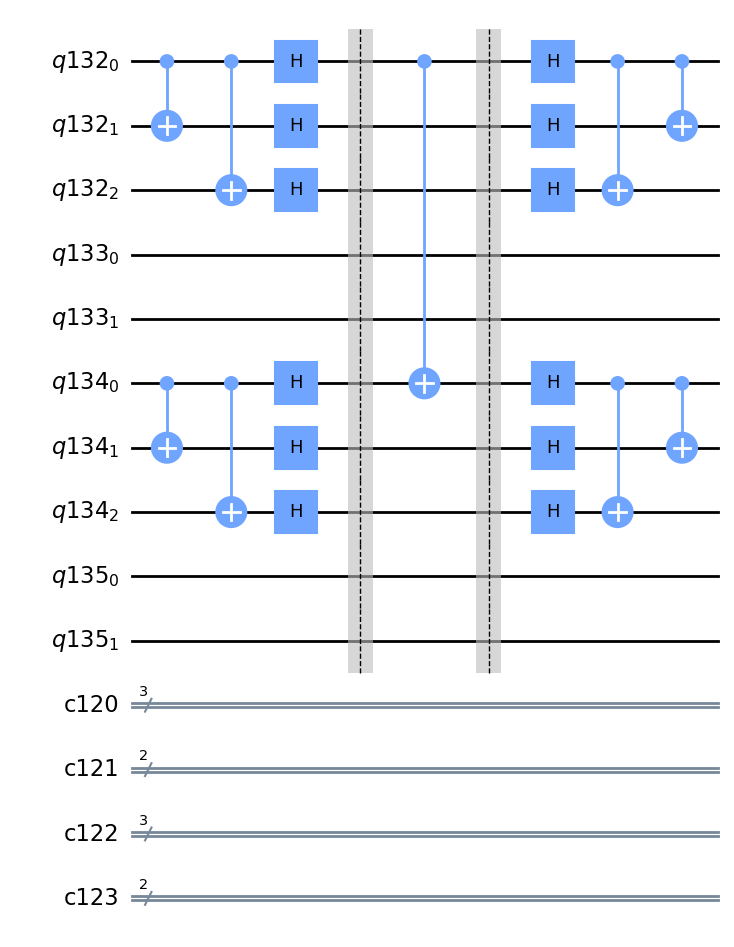

In [49]:
qr1 = QuantumRegister(3)
ar1 = QuantumRegister(2)
cqr1 = ClassicalRegister(3)
car1 = ClassicalRegister(2)
qr2 = QuantumRegister(3)
ar2 = QuantumRegister(2)
cqr2 = ClassicalRegister(3)
car2 = ClassicalRegister(2)
qc = QuantumCircuit(qr1, ar1, cqr1, car1, qr2, ar2, cqr2, car2)

encoding = RepetitionEncoding(phase_flip=True)
qc = encoding.encoding_circuit(qc, qr1)
qc = encoding.encoding_circuit(qc, qr2)
qc.barrier()

# searching for logical operator here
qc.cx(qr1[0], qr2[0])
#

qc.barrier()
encoding.decoding_circuit(qc, qr1)
encoding.decoding_circuit(qc, qr2)
display(qc.draw("mpl"))

# output what it did by considering the effective unitary between qr1[0] and qr2[0]
full_unitary = Operator(qc).data

In [42]:
from qiskit.quantum_info import Operator
import numpy as np
from itertools import product


def reduce_to_two_qubit_subspace(unitary, qubit_indices):
    """Reduces a multi-qubit unitary to a two-qubit unitary using isometric projection.

    Parameters:
        unitary (ndarray or Operator): A unitary operator in a multi-qubit Hilbert space.
        qubit_indices (list): List of two integer indices [index1, index2] specifying the two qubits to keep.

    Returns:
        ndarray: The unitary operator reduced to the two-qubit subspace.
    """
    if isinstance(unitary, Operator):
        unitary = unitary.data
    elif not isinstance(unitary, np.ndarray):
        raise ValueError("The unitary must be an ndarray or an Operator.")

    # Number of qubits in the original unitary
    num_qubits = int(np.log2(unitary.shape[0]))

    if len(qubit_indices) != 2:
        raise ValueError("qubit_indices must be of length 2.")
    if any(idx >= num_qubits for idx in qubit_indices):
        raise ValueError("Index out of range for the given number of qubits.")

    # Create the isometry
    isometry = np.zeros((4, 2**num_qubits))

    # Construct the isometry using tensor products of the basis states
    for i, (idx1, idx2) in enumerate(product(range(2), repeat=2)):
        # Build the basis state for the entire system with the specified qubits in state |idx1> and |idx2>
        basis_state = [0] * num_qubits
        basis_state[qubit_indices[0]] = idx1
        basis_state[qubit_indices[1]] = idx2
        basis_state = int("".join(map(str, basis_state)), 2)

        # Set the corresponding row in the isometry matrix
        isometry[i, basis_state] = 1

    # Apply the isometric projection to the unitary
    reduced_unitary = isometry @ unitary @ isometry.T.conj()

    return reduced_unitary

In [48]:
reduce_to_two_qubit_subspace(full_unitary, [4, 9])

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])